# 필요한 모듈 불러오기

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# 이미지 가져오기

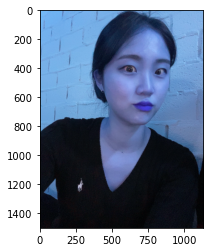

In [2]:
she_bgr = cv2.imread('data/she.JPG')
she_show = she_bgr.copy()  #bounding box, markdown 그릴 때 사용
plt.imshow(she_bgr)
plt.show()

- BGR을 RGB로 변환 (opencv의 COLOR_BGR2RGB)

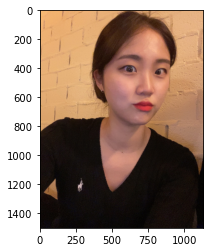

In [3]:
she_rgb = cv2.cvtColor(she_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(she_rgb)
plt.show()

# Face Detection

**hog detector 선언**

In [4]:
detector = dlib.get_frontal_face_detector()

**얼굴의 bounding box 추출**

In [5]:
dlib_rects = detector(she_rgb, 1)   #(image, number of pyramid)

## Image Pyramid
- 가장 아래에 가장 큰 해상도의 이미지를 두고 이미지의 크기를 줄여가면서 하나씩 쌓아올림
- upsampling : 데이터의 크기를 키우는 것

In [6]:
print(dlib_rects)
#찾은 bounding box 범위
#left top right bottom

rectangles[[(418, 233) (972, 788)]]


### bounding box로 찾은 얼굴 표시

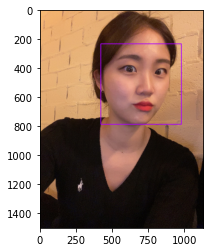

In [7]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(she_show, (l,t), (r,b), (255,0,170), 3, lineType= cv2.LINE_AA)
                                          #선의 색깔   #선 두께 
    
she_show_rgb = cv2.cvtColor(she_show, cv2.COLOR_BGR2RGB)
plt.imshow(she_show_rgb)
plt.show()

# Face LandMark

## face landmark localization
- 이목구비 위치를 추론
- face landmark에서는 detection의 결과물인 bounding box로 잘라낸 얼굴 이미지를 이용

### Object keypoint estimation
**top-down 사용**

- bounding box를 찾고 box 내부의 keypoint를 예측

### Dlib landmark localization
- bounding box 이미지에서 68개의 이목구비 위치를 찾음
- 이 때 점의 개수는 데이터셋과 논문마다 다름
- Dlib은 ibug 300-W 데이터셋으로 학습한 pretrained model 제공
- 학습 알고리즘은 regression tree의 앙상블 모델

In [8]:
#절대경로로 모델 불러오기
model_path = '/Users/kyungbeen/Downloads/아이펠/Exploration/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
#랜드마크 모델

**landmark_predictor**
- RGB 이미지와 dlib.rectangle을 입력받아 dlib.full_object_detection을 반환

In [9]:
list_landmarks = []

#bounding box마다 face_landmark를 찾아냄
for dlib_rect in dlib_rects:
    points = landmark_predictor(she_rgb, dlib_rect)
    
    #face landmark 좌표들을 저장
    list_points = list(map(lambda p : (p.x, p.y), points.parts()))
                                                # points는 dlib.full_object_detection의 객체이기 때문에
                                                # parts() 함수로 개별 위치 접근 가능
    list_landmarks.append(list_points)
                          # tuple(x,y) 68개로 이루어진 list
print(len(list_landmarks[0]))
                       #그냥 len(list_landmarks)를 하면 길이는 1이라고 나옴
                       #요소의 개수를 구해야하기 때문에 [0]을 붙여줌

68


In [10]:
list_landmarks[0]
#list_landmarks의 첫 번째 리스트

[(432, 404),
 (431, 473),
 (437, 541),
 (450, 602),
 (476, 660),
 (518, 709),
 (572, 751),
 (630, 782),
 (688, 792),
 (738, 783),
 (779, 747),
 (816, 705),
 (845, 659),
 (866, 608),
 (881, 553),
 (890, 500),
 (892, 447),
 (519, 346),
 (561, 318),
 (614, 305),
 (667, 311),
 (712, 335),
 (783, 348),
 (815, 336),
 (851, 335),
 (883, 347),
 (897, 376),
 (741, 417),
 (741, 461),
 (744, 505),
 (746, 549),
 (685, 582),
 (708, 588),
 (730, 593),
 (749, 590),
 (767, 584),
 (568, 405),
 (600, 389),
 (636, 394),
 (662, 425),
 (631, 429),
 (594, 424),
 (780, 436),
 (807, 408),
 (838, 409),
 (858, 429),
 (839, 443),
 (807, 444),
 (636, 657),
 (673, 641),
 (708, 628),
 (727, 636),
 (745, 631),
 (767, 644),
 (783, 664),
 (762, 683),
 (741, 695),
 (720, 697),
 (699, 695),
 (669, 682),
 (652, 656),
 (704, 654),
 (723, 658),
 (742, 656),
 (771, 662),
 (742, 659),
 (723, 662),
 (704, 658)]

### landmark를 bounding box가 그려진 이미지에 출력

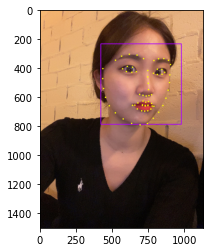

In [11]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(she_show, point, 5, (0,255,255), -1)
                            #좌표  #점 크기 #점 색깔   #두께
        
she_show_rgb = cv2.cvtColor(she_show, cv2.COLOR_BGR2RGB)
plt.imshow(she_show_rgb)
plt.show()

# 고양이 수염 스티커 적용하기

- 얼굴 위치, 카메라의 거리에 따라 픽셀 x가 다르기 때문에 비율로 계산을 해줘야 함

- 1. 스티커 위치

    x = x(nose)
    
    y = y(nose) - (height/2)
    
    
- 2. 스티커 크기

    width = height = width(bbox)
    
    
**노드에서 사용한 비율이지만 해당 이미지의 비율과는 다르다**

### 얼굴 좌표 확인

In [12]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[62])   #윗입술 정도 되는 위치
    x = landmark[62][0]
    y = landmark[62][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

(723, 658)
(x,y) : (723, 380)
(w,h) : (555, 555)


**고양이 스티커 resize**

In [13]:
cat_sticker = cv2.imread('data/cat_whiskers.png')
cat_sticker = cv2.resize(cat_sticker, (w,h))
print(cat_sticker.shape)

(555, 555, 3)


**스티커의 x, y 좌표 조정**
- 이미지의 시작점 top-left 좌표이기 때문

In [14]:
re_x = x - w//2
re_y = y - h//6
print('(x,y) : (%d,%d)'%(re_x, re_y))

# h를 나누는 숫자가 커질수록 스티커의 위치가 아래로 내려감

(x,y) : (446,288)


## 원본 이미지에 스티커 적용
### bounding box와 markdown이 적용되어 있는 이미지에 스티커 적용

In [15]:
#sticker_area : 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지

sticker_area = she_show[re_y : re_y + cat_sticker.shape[0], 
                        re_x : re_x + cat_sticker.shape[1]]

#img_show[from : to] 형식
she_show[re_y : re_y + cat_sticker.shape[0], 
         re_x: re_x + cat_sticker.shape[1]] = \
        np.where(cat_sticker== 0, cat_sticker, sticker_area).astype(np.uint8)

#스티커 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분
#np.where을 통해 img_sticker가 0인 부분은 cat_sticker를 사용하고
#0이 아닌 부분을 sticker_area를 사용

In [16]:
sticker_area.shape

(555, 555, 3)

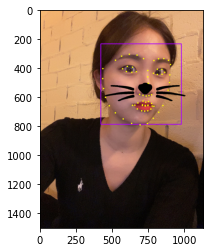

In [17]:
plt.imshow(cv2.cvtColor(she_show, cv2.COLOR_BGR2RGB))
plt.show()

## bounding box와 landmark를 제거하고 최종 결과만 출력

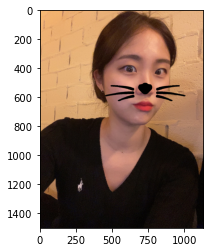

In [18]:
sticker_area = she_bgr[re_y:re_y + cat_sticker.shape[0],
                       re_x:re_x + cat_sticker.shape[1]]

she_bgr[re_y:re_y + cat_sticker.shape[0],
        re_x:re_x + cat_sticker.shape[1]] = \
        np.where(cat_sticker==0, cat_sticker, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(she_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 이미지 불러오기

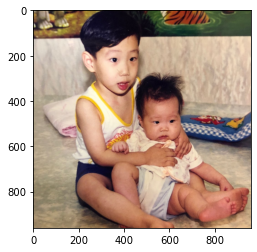

In [19]:
babies_bgr = cv2.imread('data/babies.jpeg')
babies_show = babies_bgr.copy()  #bounding box, markdown 그릴 때 사용

babies_rgb = cv2.cvtColor(babies_bgr, cv2.COLOR_BGR2RGB)   #RGB로 변경

plt.imshow(babies_rgb)
plt.show()

처음 사용한 이미지는 한 인물이 담긴 이미지이고, 정면을 바라보고 있으며 얼굴을 가리는 장애물이 없어 비교적 얼굴 인식이 쉬운 데이터였다.

조금 더 복잡하고 어려운 이미지를 다뤄보고자

1) 얼굴의 크기가 작고,

2) 두 인물이 담겨있고,

3) 아기의 사진이며, 

4) 얼굴의 각도가 정면이 아닌 데이터를 사용해보고자 한다.

In [20]:
detector_b = dlib.get_frontal_face_detector() #detector 선언
dlib_rects_b = detector_b(babies_rgb, 1)      #bounding box 추출
                    #(image, number of pyramid)  

## bounding box로 찾은 얼굴 표시

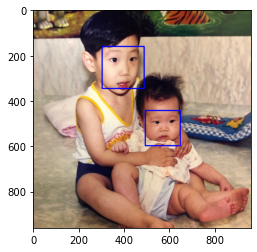

In [21]:
for dlib_rect in dlib_rects_b:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(babies_show, (l,t), (r,b), (255,0,0), 3, lineType= cv2.LINE_AA)
                                          #선의 색깔   #선 두께 
    
babies_show_rgb = cv2.cvtColor(babies_show, cv2.COLOR_BGR2RGB)
plt.imshow(babies_show_rgb)
plt.show()

왼쪽 아이의 손이 오른 쪽 아이의 얼굴에 가까이 있어서 

오른쪽 아이 얼굴의 bounding box가 아이의 턱 끝에서 끝나지 않은 것 같다.

첫 번 째 이미지처럼 온전히 딱 들어맞진 않지만, 그래도 만족스러운 결과가 도출되었다.

# Face LandMark

## face landmark localization 
### Object keypoint estimation
**top-down 사용**



In [22]:
#절대경로로 모델 불러오기
model_path = '/Users/kyungbeen/Downloads/아이펠/Exploration/model/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
#랜드마크 모델

**landmark predictor**

In [23]:
list_landmarks_b = []

#bounding box마다 face_landmark를 찾아냄
for dlib_rect in dlib_rects_b:
    points_b = landmark_predictor(babies_rgb, dlib_rect)
    
    #face landmark 좌표들을 저장
    list_points_b = list(map(lambda p : (p.x, p.y), points_b.parts()))
                                                # points_b는 dlib.full_object_detection의 객체이기 때문에
                                                # parts() 함수로 개별 위치 접근 가능
    list_landmarks_b.append(list_points_b)
                          # tuple(x,y) 68개로 이루어진 list
print(len(list_landmarks_b[0]))
                       #그냥 len(list_landmarks_b)를 하면 길이는 1이라고 나옴
                       #요소의 개수를 구해야하기 때문에 [0]을 붙여줌

68


### landmark를 bounding box가 그려진 이미지에 출력

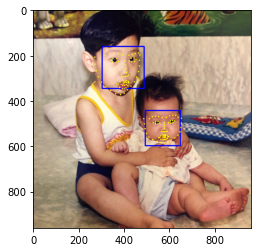

In [24]:
for landmark in list_landmarks_b:
    for point in landmark:
        cv2.circle(babies_show, point, 3, (0,255,255), -1)
                            #좌표  #점 크기 #점 색깔   #두께
        
babies_show_rgb = cv2.cvtColor(babies_show, cv2.COLOR_BGR2RGB)
plt.imshow(babies_show_rgb)
plt.show()

안겨있는 아기가 markdown으로 인해 마오리족 아이같이 출력되긴 했지만, 

이목구비에 맞게 markdown이 잘 적용되었음을 확인했다.

# 고양이 수염 스티커 적용하기

### 얼굴 좌표 확인

In [25]:
babies_coordinates = []
babies_rect_size = []

for dlib_rect, landmark in zip(dlib_rects_b, list_landmarks_b):
    print(landmark[62])   #윗입술 정도 되는 위치
    x = landmark[62][0]
    y = landmark[62][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    babies_coordinates.append((x,y))   #얼굴의 좌표값들을 저장
    babies_rect_size.append((w,h))     #bounding box 사이즈 저장

(404, 320)
(578, 555)


인식된 얼굴이 두 개이므로 두 좌표가 반환된다.

또한 두 bounding box의 사이즈도 다르기 때문에

각 detection의 좌표값과 bounding box를 튜플로 형성한 후 따로 리스트에 넣어 저장한다.

In [26]:
print(babies_rect_size)
#bounding box 사이즈

[(186, 186), (155, 155)]


In [27]:
print(babies_coordinates)
#얼굴 좌표값

[(404, 227), (578, 477)]


**고양이 스티커 resize**

두 개의 사이즈가 있으므로 resize를 따로 처리를 해준다.

In [28]:
# 큰 bounding box의 사이즈로 resize
cat_sticker_bb = cv2.imread('data/cat_whiskers.png')
cat_sticker_bb = cv2.resize(cat_sticker_bb, babies_rect_size[0])
print(cat_sticker_bb.shape)

(186, 186, 3)


In [29]:
# 작은 bounding box의 사이즈로 resize
cat_sticker_bs = cv2.imread('data/cat_whiskers.png')
cat_sticker_bs = cv2.resize(cat_sticker_bs, babies_rect_size[1])
print(cat_sticker_bs.shape)

(155, 155, 3)


### 스티커의 x, y 좌표 조정
- 이미지의 시작점 top-left 좌표이기 때문

In [30]:
# 큰 bounding box의 좌표값을 변수에 할당
bb_x = babies_coordinates[0][0]
bb_y = babies_coordinates[0][1]

# 작은 bounding box의 좌표값을 변수에 할당
bs_x = babies_coordinates[1][0]
bs_y = babies_coordinates[1][1]

In [31]:
# 큰 bounding box의 w, h를 변수에 할당
bb_w = babies_rect_size[0][0]
bb_h = babies_rect_size[0][1]

# 작은 bounding box의 w, h를 변수에 할당
bs_w = babies_rect_size[1][0]
bs_h = babies_rect_size[1][1]

In [32]:
#큰 bounding box의 좌표 조정
re_bb_x = bb_x - bb_w//2
re_bb_y = bb_y - bb_h//6
print('(x,y) : (%d,%d)'%(re_bb_x, re_bb_y))

# h를 나누는 숫자가 커질수록 스티커의 위치가 아래로 내려감

(x,y) : (311,196)


In [33]:
#작은 bounding box의 좌표 조정
re_bs_x = bs_x - bs_w//2
re_bs_y = bs_y - bs_h//6
print('(x,y) : (%d,%d)'%(re_bs_x, re_bs_y))

(x,y) : (501,452)


## 원본 이미지에 스티커 적용
### bounding box와 markdown이 적용되어 있는 이미지에 스티커 적용

**큰 bounding box에 적용**

In [34]:
#sticker_area_bb : 큰 bounding box에서 스티커를 적용할 위치를 crop한 이미지

sticker_area_bb = babies_show[re_bb_y : re_bb_y + cat_sticker_bb.shape[0], 
                        re_bb_x : re_bb_x + cat_sticker_bb.shape[1]]

#img_show[from : to] 형식
babies_show[re_bb_y : re_bb_y + cat_sticker_bb.shape[0], 
         re_bb_x: re_bb_x + cat_sticker_bb.shape[1]] = \
        np.where(cat_sticker_bb== 0, cat_sticker_bb, sticker_area_bb).astype(np.uint8)

#np.where을 통해 img_sticker가 0인 부분은 cat_sticker를 사용하고
#0이 아닌 부분을 sticker_area를 사용

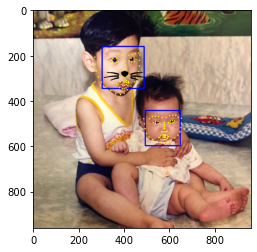

In [35]:
plt.imshow(cv2.cvtColor(babies_show, cv2.COLOR_BGR2RGB))
plt.show()

**작은 bounding box에 적용**

In [36]:
#sticker_area_bs : 이미지에서 스티커를 적용할 위치를 crop한 이미지

sticker_area_bs = babies_show[re_bs_y : re_bs_y + cat_sticker_bs.shape[0], 
                        re_bs_x : re_bs_x + cat_sticker_bs.shape[1]]

#img_show[from : to] 형식
babies_show[re_bs_y : re_bs_y + cat_sticker_bs.shape[0], 
         re_bs_x: re_bs_x + cat_sticker_bs.shape[1]] = \
        np.where(cat_sticker_bs == 0, cat_sticker_bs, sticker_area_bs).astype(np.uint8)

#np.where을 통해 img_sticker가 0인 부분은 cat_sticker를 사용하고
#0이 아닌 부분을 sticker_area를 사용

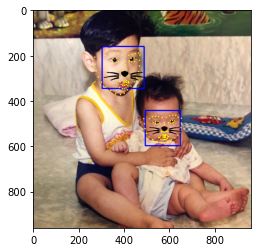

In [37]:
plt.imshow(cv2.cvtColor(babies_show, cv2.COLOR_BGR2RGB))
plt.show()

## bounding box와 landmark를 제거하고 최종 결과만 출력

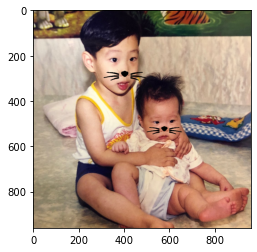

In [38]:
sticker_area_bb = babies_bgr[re_bb_y : re_bb_y + cat_sticker_bb.shape[0], 
                        re_bb_x : re_bb_x + cat_sticker_bb.shape[1]]

sticker_area_bs = babies_bgr[re_bs_y : re_bs_y + cat_sticker_bs.shape[0], 
                        re_bs_x : re_bs_x + cat_sticker_bs.shape[1]]


babies_bgr[re_bb_y : re_bb_y + cat_sticker_bb.shape[0], 
         re_bb_x: re_bb_x + cat_sticker_bb.shape[1]] = \
        np.where(cat_sticker_bb== 0, cat_sticker_bb, sticker_area_bb).astype(np.uint8)

babies_bgr[re_bs_y : re_bs_y + cat_sticker_bs.shape[0], 
         re_bs_x: re_bs_x + cat_sticker_bs.shape[1]] = \
        np.where(cat_sticker_bs == 0, cat_sticker_bs, sticker_area_bs).astype(np.uint8)

plt.imshow(cv2.cvtColor(babies_bgr, cv2.COLOR_BGR2RGB))
plt.show()

두 아이의 얼굴이 측면을 향하고 있다고 생각했는데,

스티커 적용 이후 보니 시선이 측면일 뿐 얼굴은 거의 정면을 향하고 있다고 여겨진다.

그래서 두 얼굴 다 고양이 스티커가 적절하게 적용된 것이라고 생각한다.

- 구글링 하다가 찾은 새로운 detection 방법

In [39]:
#face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
#sample_image = babies_rgb
#gray = cv2.cvtColor(sample_image, cv2.COLOR_BGR2GRAY)
#faces = face_cascade.detectMultiScale(gray)

#검출한 얼굴에 사각형으로 표시
#for (x, y, w, h) in faces:
#    cv2.rectangle(sample_image, (x,y), (x+w, y+h), (255, 0, 0), 2)

#cv2.imshow('sample', sample_image)
#cv2.waitKey()

파일 경로도 문제가 없는데 실행되지 않음

# 회고

    이미지 detection은 처음 경험해보아서인지 재미있었다. 파이썬을 접한 지는 조금 됐지만 매번 새롭고 신기하다. 


    한 번 입력한 건 계속 기억할 수 있는 기계가 부러웠다. 

    코드 한 번 입력하면 뒤에 무슨 코드를 계속 입력하든 기억하고 있는 것이 부러웠다. 

    이젠 사람과의 경쟁에서 확장되어 기계까지 경쟁해야할 것 같다는 생각에 속이 좀 탔다. 

    그만큼 열심히 해야한다는 것이겠지. 


    내 사진에 고양이 스티커 하나 붙이는 게 이렇게 많은 과정이 필요한 지 처음 알게 되었다. 
    
    모든 카메라 어플 개발자분들이 존경스러웠다. 
    
    인식이 잘 안되는 필터를 쓸 때 뭐이렇게 만들었나 했는데, 이젠 많이 힘드셨겠다 라고 생각할 것 같다.  

- 얼굴이 측면으로 돌아가있는 경우, 스티커를 회전 시키는 방법이 궁금해서 찾아보았으나 어쩔 수 없는 부분이었다. 과연 앞으로도 어쩔 수 없는 부분으로 남겨질지 궁금하다. 아마 원근감까지 조정하여 언젠가 3D처럼 적용할 기술이 이미 존재할 것 같다. 하지만 현재 미모지나 제페토처럼 3D이미지(?)가 성행하기 시작하는데 과연 2D를 그렇게 조정할 기술이 필요할까 싶다.


-  스티커를 붙였는데 위치 등이 마음에 안 들 경우, 이미지를 다시 불러와서 수정해야하는 것이 불편했다.


-  bounding box를 더 정밀하게 출력할 수 없는 지 궁금해서 찾아보았는데,xml을 다운받아서 코드를 실행하는 방법이 있었다. 
    직접 시도해보았는데 파일이 무거워서인지 노트북 성능이 좋지 않아서인지 계속 기다려도 코드가 실행되지 않았다.